# Explore here

In [117]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import math

df = pd.read_csv("../acea-water-prediction/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [119]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2006-03-14,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,2006-03-15,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,2006-03-16,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,2006-03-17,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,2006-03-18,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [120]:
print(f"Valores faltantes: \n{df.isnull().sum()}")

Valores faltantes: 
Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
dtype: int64


In [121]:
df = df[df['Rainfall_Bastia_Umbra'].notna()].reset_index(drop=True)
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df['Rainfall_Bastia_Umbra'].isnull().sum()

np.int64(0)

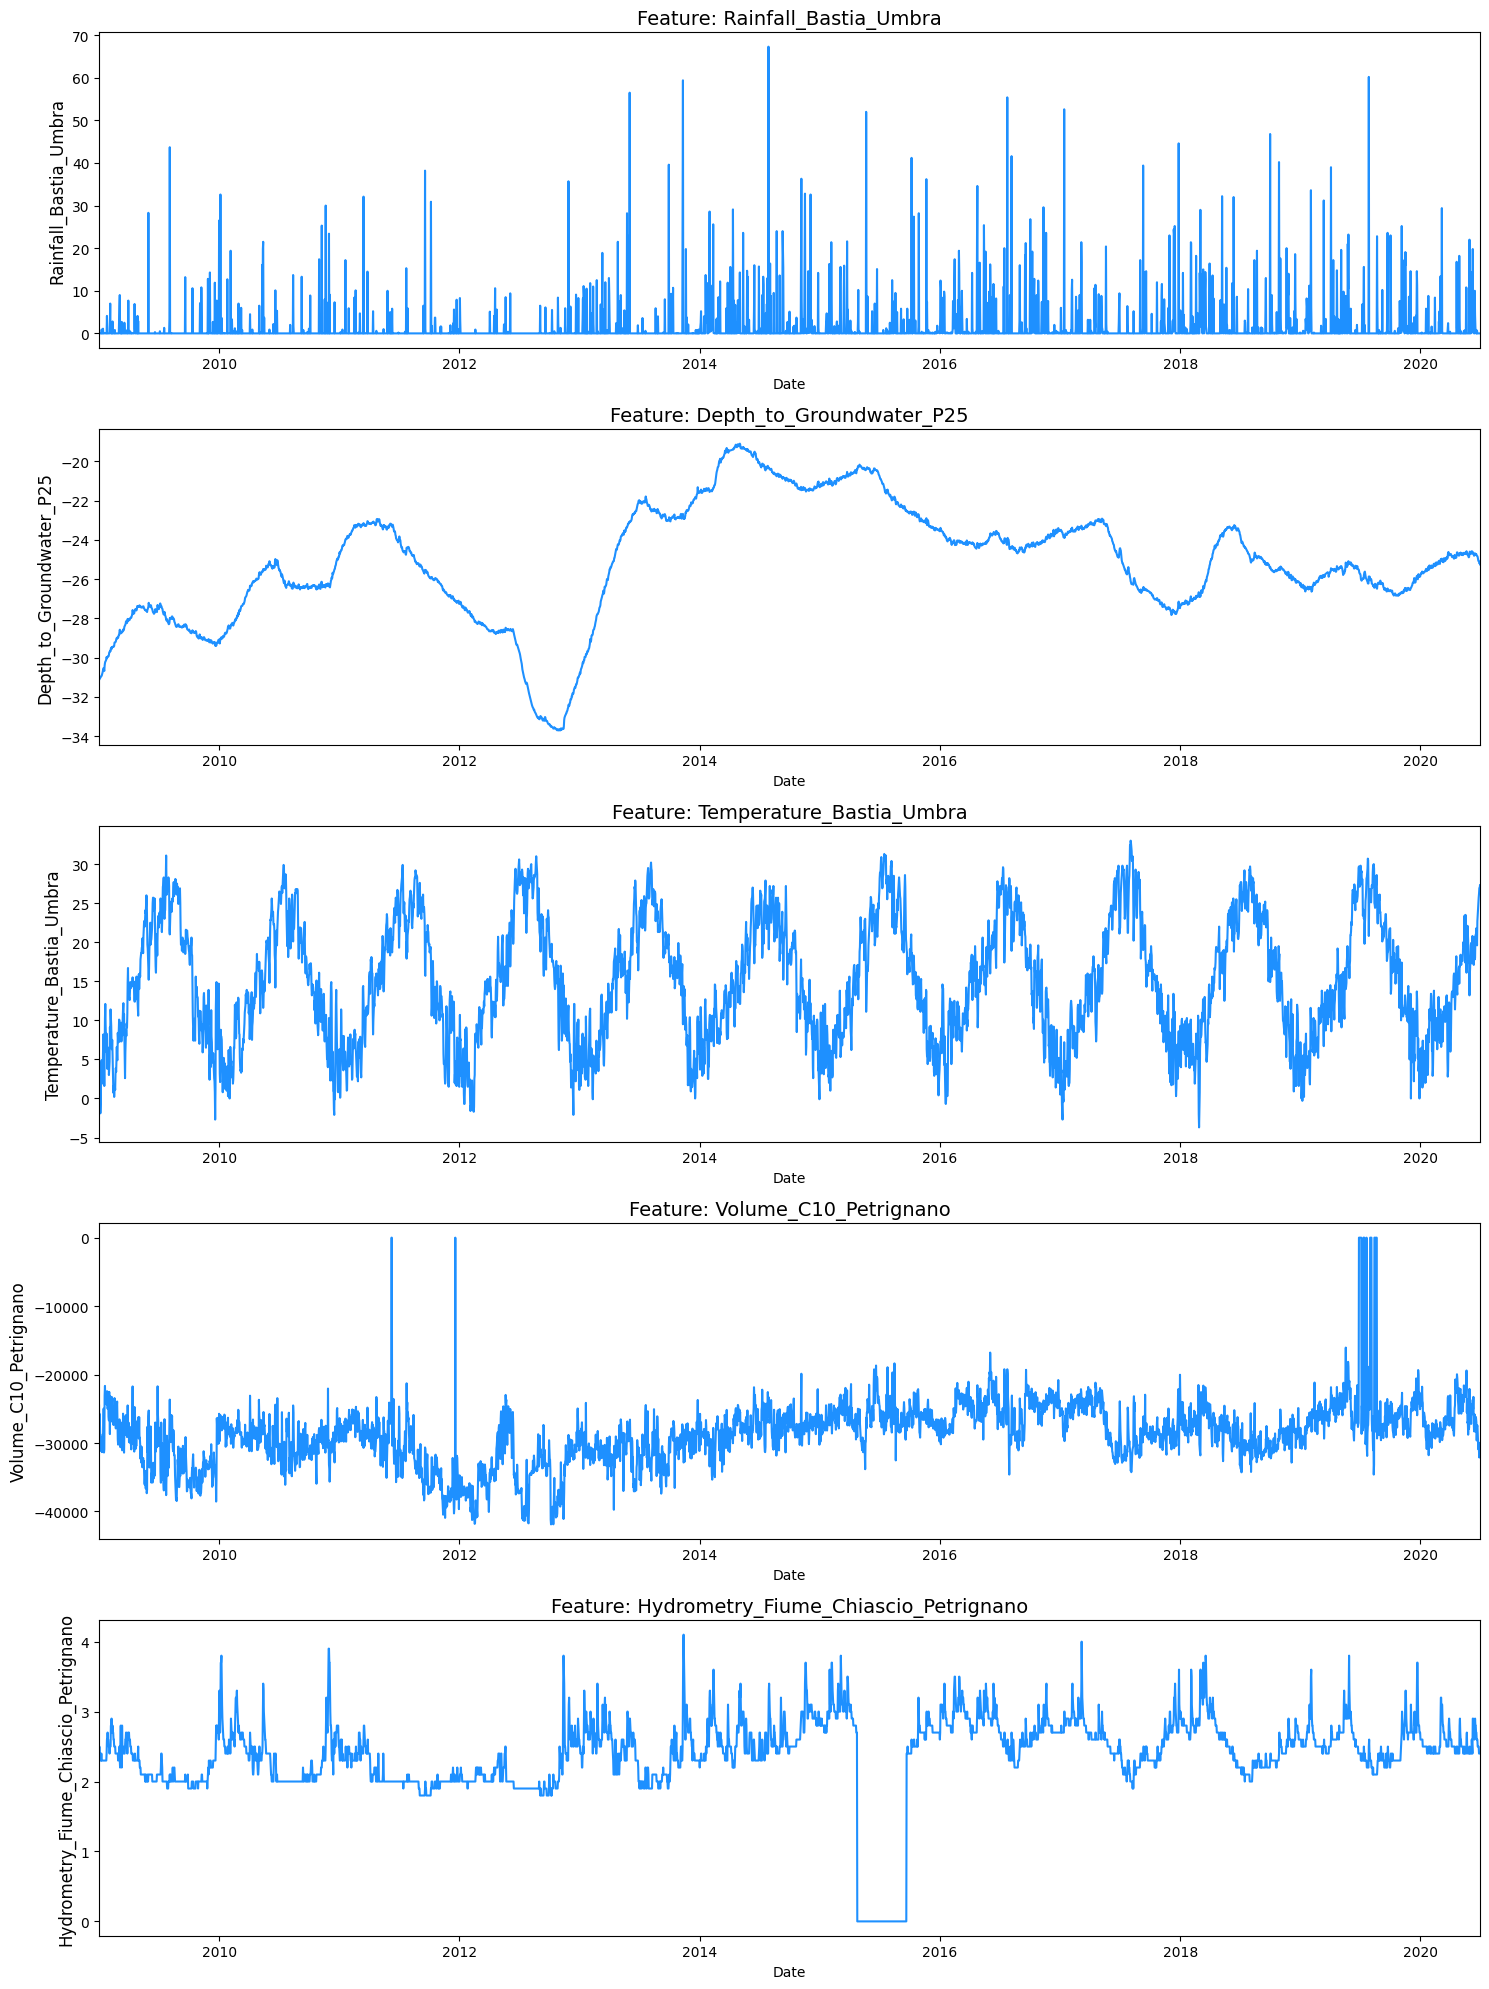

In [122]:
n_features = len(df.columns) - 1
f, ax = plt.subplots(nrows=n_features, ncols=1, figsize=(15, 20))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    sns.lineplot(x=df['Date'], y=df[column], ax=ax[i], color='dodgerblue')
    ax[i].set_title(f'Feature: {column}', fontsize=14)
    ax[i].set_ylabel(column, fontsize=12)
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In [124]:
df['Rainfall_Bastia_Umbra'] = df['Rainfall_Bastia_Umbra'].fillna(df['Rainfall_Bastia_Umbra'].median())
df['Depth_to_Groundwater_P25'] = df['Depth_to_Groundwater_P25'].fillna(df['Depth_to_Groundwater_P25'].median())
df['Temperature_Bastia_Umbra'] = df['Temperature_Bastia_Umbra'].fillna(df['Temperature_Bastia_Umbra'].median())
df['Volume_C10_Petrignano'] = df['Volume_C10_Petrignano'].fillna(df['Volume_C10_Petrignano'].median())
df['Hydrometry_Fiume_Chiascio_Petrignano'] = df['Hydrometry_Fiume_Chiascio_Petrignano'].fillna(df['Hydrometry_Fiume_Chiascio_Petrignano'].median())

print("Valores faltantes después de imputar con mediana:")
print(df.isnull().sum())


Valores faltantes después de imputar con mediana:
Date                                    0
Rainfall_Bastia_Umbra                   0
Depth_to_Groundwater_P25                0
Temperature_Bastia_Umbra                0
Volume_C10_Petrignano                   0
Hydrometry_Fiume_Chiascio_Petrignano    0
dtype: int64


In [125]:
downsample = df[['Date', 'Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra', 'Volume_C10_Petrignano', 'Hydrometry_Fiume_Chiascio_Petrignano']].resample('7D', on='Date').median().reset_index(drop=False)
df = downsample.copy()

In [126]:
print("Valores faltantes después del resampling semanal:")
print(df.isnull().sum())

print("Primeras filas del DataFrame re-muestreado:")
df.head()

Valores faltantes después del resampling semanal:
Date                                    0
Rainfall_Bastia_Umbra                   0
Depth_to_Groundwater_P25                0
Temperature_Bastia_Umbra                0
Volume_C10_Petrignano                   0
Hydrometry_Fiume_Chiascio_Petrignano    0
dtype: int64
Primeras filas del DataFrame re-muestreado:


,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2009-01-01,0.0,-31.05,1.5,-28785.888,2.4
1,2009-01-08,0.0,-30.83,4.3,-29845.152,2.3
2,2009-01-15,0.0,-30.41,7.8,-23793.696,2.3
3,2009-01-22,0.0,-29.97,6.0,-23939.712,2.6
4,2009-01-29,0.0,-29.74,4.7,-25226.208,2.5


In [127]:
df['year'] = df['Date'].dt.year 
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['day_of_year'] = df['Date'].dt.dayofyear
df['week_of_year'] = df['Date'].dt.isocalendar().week
df['quarter'] = df['Date'].dt.quarter 

df['season'] = df['month'] % 12 // 3 + 1

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)  

print("Primeras filas del DataFrame con características temporales:")
df.head()

Primeras filas del DataFrame con características temporales:


,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,year,month,day,day_of_year,week_of_year,quarter,season,month_sin,month_cos
0,2009-01-01,0.0,-31.05,1.5,-28785.888,2.4,2009,1,1,1,1,1,1,0.5,0.866025
1,2009-01-08,0.0,-30.83,4.3,-29845.152,2.3,2009,1,8,8,2,1,1,0.5,0.866025
2,2009-01-15,0.0,-30.41,7.8,-23793.696,2.3,2009,1,15,15,3,1,1,0.5,0.866025
3,2009-01-22,0.0,-29.97,6.0,-23939.712,2.6,2009,1,22,22,4,1,1,0.5,0.866025
4,2009-01-29,0.0,-29.74,4.7,-25226.208,2.5,2009,1,29,29,5,1,1,0.5,0.866025


In [128]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'Rainfall_Bastia_Umbra', 'Temperature_Bastia_Umbra', 'Volume_C10_Petrignano', 
    'Hydrometry_Fiume_Chiascio_Petrignano', 'Depth_to_Groundwater_P25'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

for column in core_columns:
    df[f'{column}_lag_4'] = df[f'{column}_seasonal'].shift(4)
    df[f'{column}_lag_8'] = df[f'{column}_seasonal'].shift(8)
    df[f'{column}_lag_12'] = df[f'{column}_seasonal'].shift(12)

df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,year,month,day,day_of_year,...,Temperature_Bastia_Umbra_lag_12,Volume_C10_Petrignano_lag_4,Volume_C10_Petrignano_lag_8,Volume_C10_Petrignano_lag_12,Hydrometry_Fiume_Chiascio_Petrignano_lag_4,Hydrometry_Fiume_Chiascio_Petrignano_lag_8,Hydrometry_Fiume_Chiascio_Petrignano_lag_12,Depth_to_Groundwater_P25_lag_4,Depth_to_Groundwater_P25_lag_8,Depth_to_Groundwater_P25_lag_12
0,2009-01-01,0.0,-31.05,1.5,-28785.888,2.4,2009,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-08,0.0,-30.83,4.3,-29845.152,2.3,2009,1,8,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-15,0.0,-30.41,7.8,-23793.696,2.3,2009,1,15,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-22,0.0,-29.97,6.0,-23939.712,2.6,2009,1,22,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-29,0.0,-29.74,4.7,-25226.208,2.5,2009,1,29,29,...,NaN,1279.290753,NaN,NaN,0.311337,NaN,NaN,-0.64533,NaN,NaN


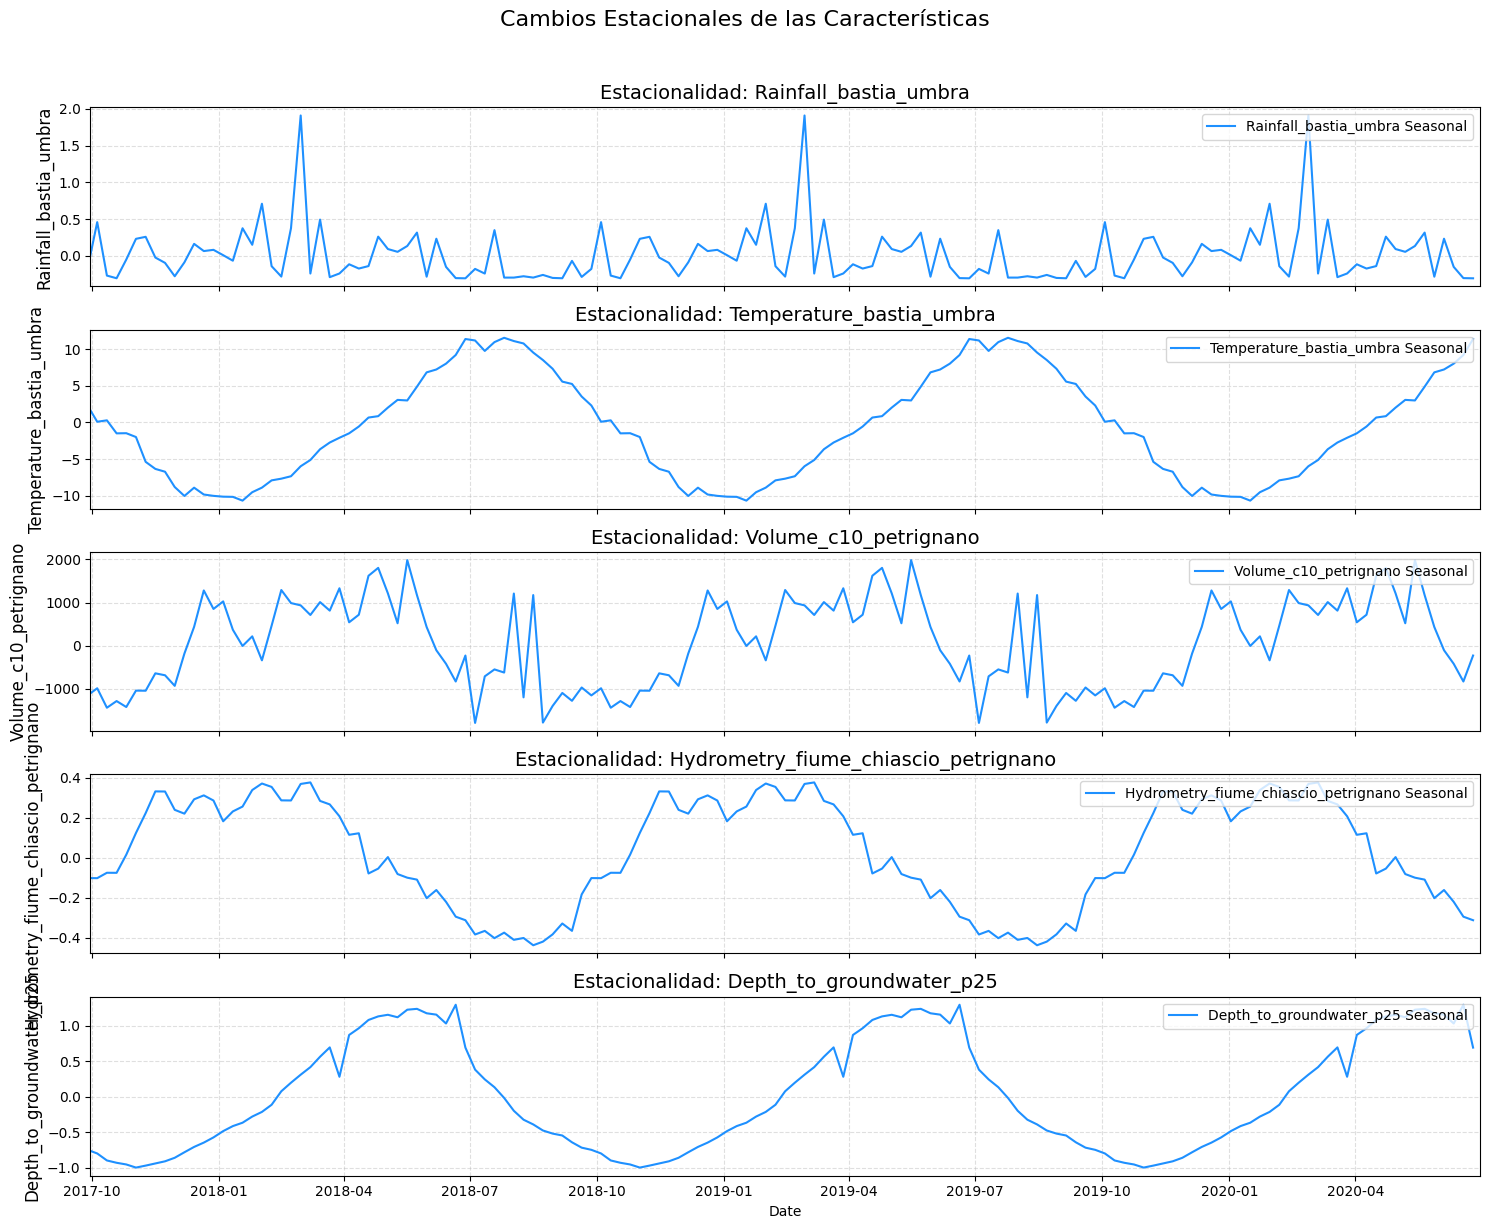

In [129]:
fig, axes = plt.subplots(nrows=len(core_columns), ncols=1, figsize=(15, 12), sharex=True)
fig.suptitle('Cambios Estacionales de las Características', fontsize=16, y=1.02)

for i, column in enumerate(core_columns):
    ax = axes[i]

    sns.lineplot(
        x=df['Date'], 
        y=df[f'{column}_seasonal'], 
        ax=ax, 
        color='dodgerblue', 
        label=f'{column.capitalize()} Seasonal'
    )

    ax.set_title(f'Estacionalidad: {column.capitalize()}', fontsize=14)
    ax.set_ylabel(column.capitalize(), fontsize=12)
    ax.set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(visible=True, linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [130]:
N_SPLITS = 3

X = df['Date']
y = df['Depth_to_Groundwater_P25']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [131]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['Date', 'Depth_to_Groundwater_P25']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


In [132]:
model = Prophet()
model.fit(train)

y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

20:12:01 - cmdstanpy - INFO - Chain [1] start processing
20:12:01 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 1.182522591174196


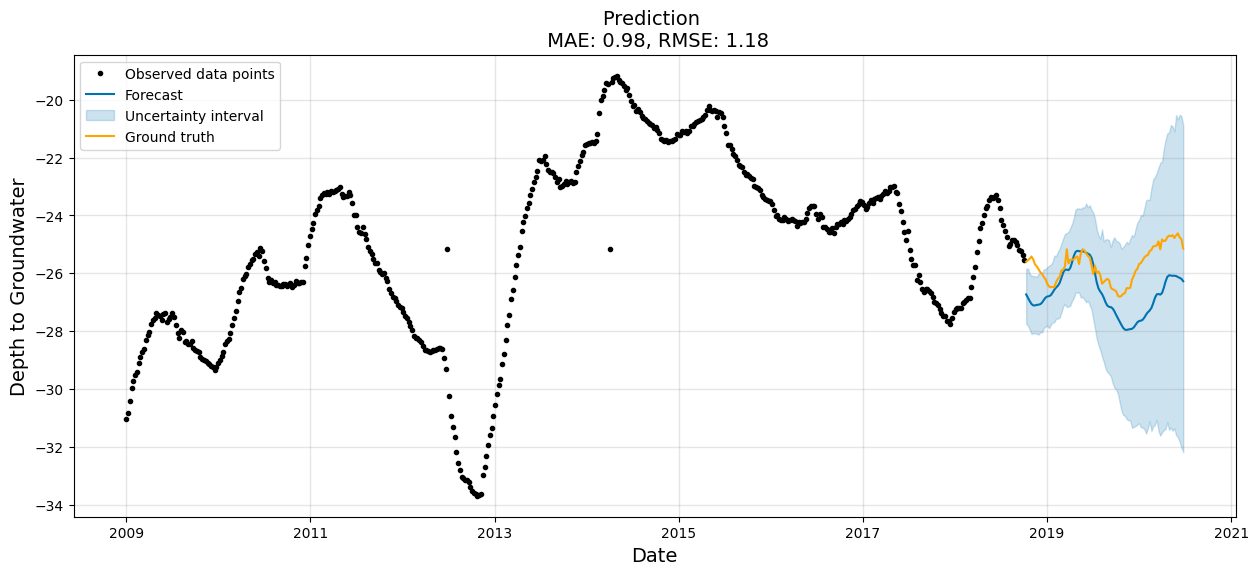

In [133]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()